In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import numpy as np
import matplotlib.pyplot as plt
from feature_manager import FeatureManager
from dnn_multi_class_classifier import MultiClassDNNClassifer
from sklearn.preprocessing import LabelEncoder
from random import randint
from keras import callbacks
from keras import losses
from visualizer import *
from keras.utils import np_utils

2023-01-15 03:46:10.271919: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-15 03:46:10.272036: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-15 03:46:10.272046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [14]:
data = pd.read_csv("../data/BTCUSDT-1h.csv", parse_dates=["Open Time"], index_col = "Open Time")
fm: FeatureManager = FeatureManager()
fm.build_feature(data=data,lags=5)

tp = 0.05
sl = 0.025
md = 48

fm.prepare_trade_forward_data(
    data=fm.df,
    take_profit_rate=tp,
    stop_loss_rate=sl,
    max_duration=md
)

In [15]:
fm.df["trade_signal"].value_counts()

0    26214
1    10503
2    10111
Name: trade_signal, dtype: int64

In [16]:
classifier = MultiClassDNNClassifer()
classifier.prepare_data(data = fm.df,cols = fm.cols,random_state=randint(0,100),target_col="trade_signal")



Train = 32779, Val = 7024, Test = 7025, All = 46828


In [17]:
classifier.configure(hu = 100, dropout=True, class_num = 3, input_dim=len(fm.cols))
classifier.run(gpu = True,epochs = 200, patience = 5)
classifier.model.evaluate(classifier.x_test,classifier.y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
_________________________________________________________________


2023-01-15 03:48:41.553038: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-15 03:48:41.553079: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: andy-GA-970A-D3
2023-01-15 03:48:41.553090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: andy-GA-970A-D3
2023-01-15 03:48:41.553215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 520.61.5
2023-01-15 03:48:41.553246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 520.61.5
2023-01-15 03:48:41.553257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 520.61.5


Epoch 1/200

Epoch 1: val_loss improved from inf to 1.18230, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 5s - loss: 1.7232 - accuracy: 0.3938 - val_loss: 1.1823 - val_accuracy: 0.2645 - 5s/epoch - 4ms/step
Epoch 2/200

Epoch 2: val_loss improved from 1.18230 to 1.16055, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 4s - loss: 1.6269 - accuracy: 0.4453 - val_loss: 1.1605 - val_accuracy: 0.2603 - 4s/epoch - 4ms/step
Epoch 3/200

Epoch 3: val_loss improved from 1.16055 to 1.15345, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 4s - loss: 1.6078 - accuracy: 0.4553 - val_loss: 1.1534 - val_accuracy: 0.2510 - 4s/epoch - 3ms/step
Epoch 4/200

Epoch 4: val_loss improved from 1.15345 to 1.15171, saving model to ../data/model_dnn_checkpoint.h5
1025/1025 - 4s - loss: 1.5936 - accuracy: 0.4670 - val_loss: 1.1517 - val_accuracy: 0.2528 - 4s/epoch - 3ms/step
Epoch 5/200

Epoch 5: val_loss improved from 1.15171 to 1.14704, saving model to ../data/model_dnn_c

[0.9795088768005371, 0.5046263337135315]

In [ ]:
pd.DataFrame(classifier.y_test).value_counts()

In [ ]:
pd.DataFrame(classifier.pred_class).value_counts()


======= Lap 1 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
_________________________________________________________________
Train = 32779, Val = 7024, Te

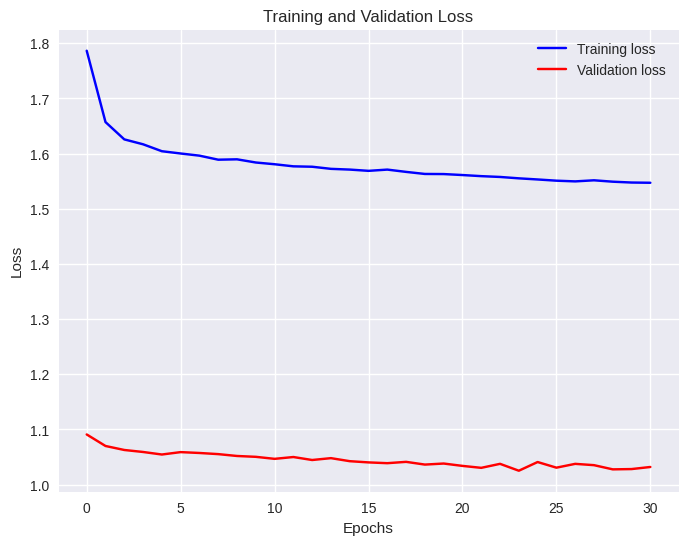

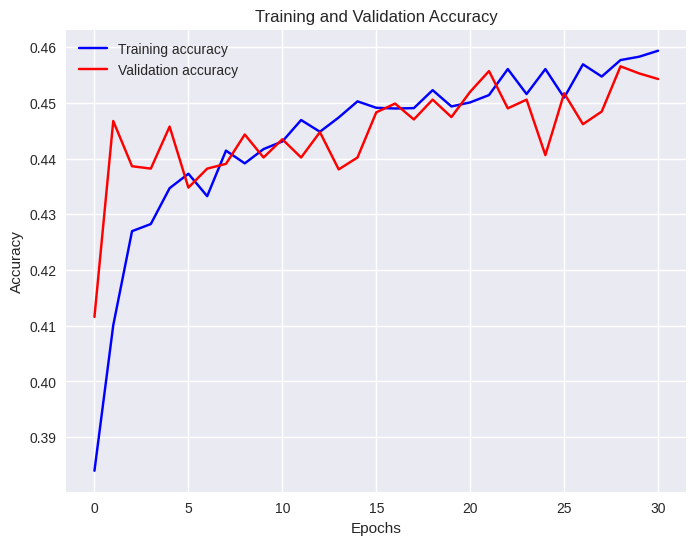

220/220 [==============================] - 0s 2ms/step - loss: 1.0348 - accuracy: 0.4470

======= Lap 2 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
______

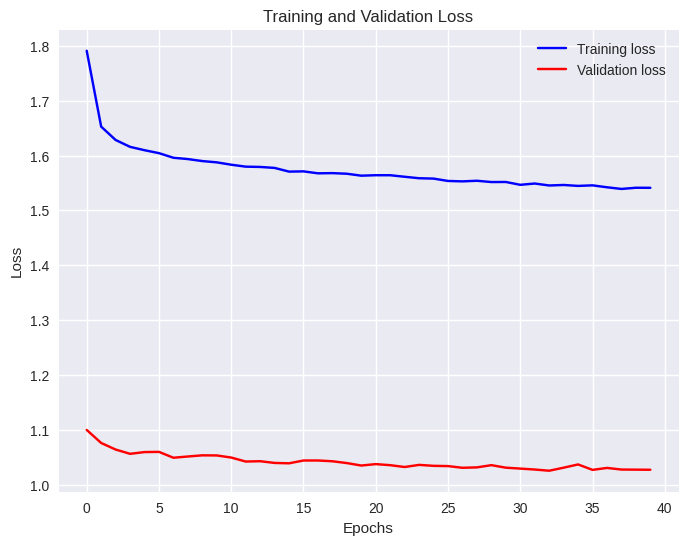

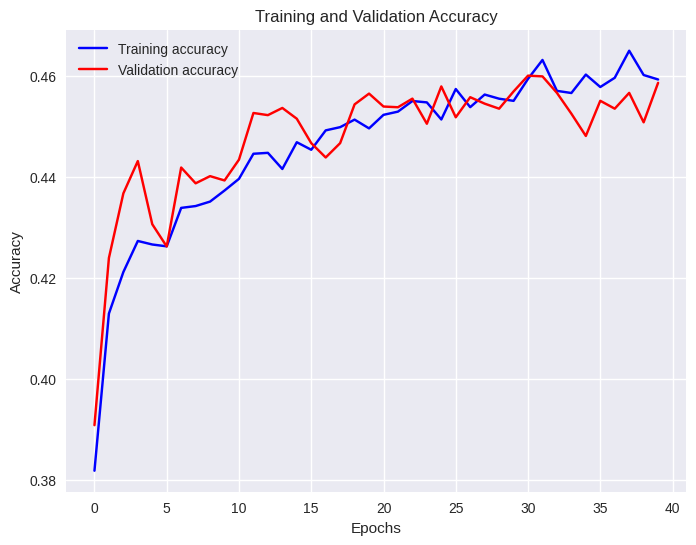

220/220 [==============================] - 0s 2ms/step - loss: 1.0222 - accuracy: 0.4534

======= Lap 3 =======
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               11100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 25)                2525      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                                 
Total params: 13,703
Trainable params: 13,703
Non-trainable params: 0
______

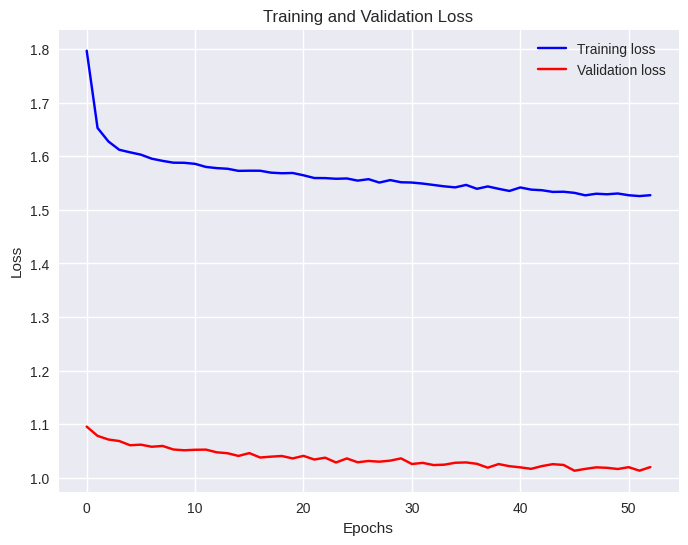

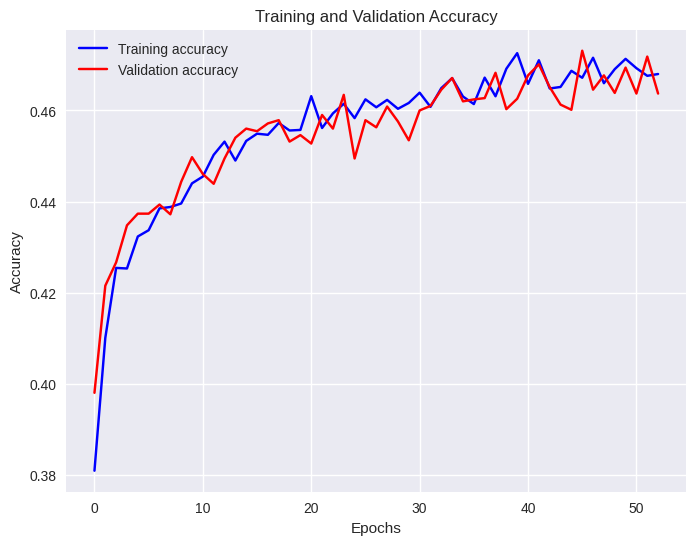

220/220 [==============================] - 0s 2ms/step - loss: 1.0192 - accuracy: 0.4649

Accuracy mean: 0.4550889730453491, std: 0.00742127963108604
Loss mean: 1.0253970623016357, std: 0.006765227662263152


In [18]:
acc_list = []
loss_list = []
laps = 3

for i in range (0,laps):
    print("\n======= Lap {} =======".format(i+1))
    callbacks.backend.clear_session()
    
    classifier = MultiClassDNNClassifer()
    
    classifier.configure(
        hu = 100, 
        dropout=True, 
        input_dim=len(fm.cols),
        class_num=3
    )
    
    classifier.prepare_data(
        data = fm.df,
        cols = fm.cols,
        shuffle = True, 
        random_state=i+1,
        target_col="trade_signal"
    )
    
    classifier.run(gpu = True,epochs=100, patience=7)
    classifier.visualize_loss()
    classifier.visualize_accuracy()
    
    test_results = classifier.model.evaluate(
        classifier.x_test,
        classifier.y_test
    )

    acc_list.append(test_results[1])
    loss_list.append(test_results[0])

acc_arr = np.array(acc_list)
loss_arr = np.array(loss_list)

print("\n======")
print("Accuracy mean: {}, std: {}".format(acc_arr.mean(),acc_arr.std()))
print("Loss mean: {}, std: {}".format(loss_arr.mean(),loss_arr.std()))
print("======")